# Elliptic Geometry of Multivariate Normal Distribution (Gaussian Distribution)

The paper [Understanding Statistical Methods through Elliptical Geometry](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.259.3710&rank=1) by Michael Friendly, Georges Monette, John Fox, Michael Friendly, Georges Monette and John Fox is a great resource for visualizing the geometry of the [Multivariate Normal Distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution).

The [singular value decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition) will also play a role here and the summary from [Venkatesan Guruswami](http://www.cs.cmu.edu/~venkatg/) that you can find [here](http://www.cs.cmu.edu/~venkatg/teaching/CStheory-infoage/SVD-chap.pdf) gives you a good background on that. In addition I suggest you have a look at chapter 12.2.3 "Singular value decomposition (SVD)" in [Machine Learning: A Probabilistic Perspective](https://www.amazon.com/Machine-Learning-Probabilistic-Perspective-Computation/dp/0262018020).

# Standard python imports

In [1]:
%%capture
%matplotlib inline
import locale
locale.setlocale(locale.LC_ALL, 'C')
import os, timeit, collections

import IPython.display

import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.linalg, pandas as pd, \
    matplotlib.pyplot as plt, matplotlib.dates, matplotlib.ticker, xarray as xr, seaborn as sns
import sklearn.preprocessing

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(suppress=True)
np.set_printoptions(precision=8)
np.core.arrayprint._line_width = 180

sns.set()

SEED = 42
np.random.seed(SEED)

In [2]:
%load_ext autoreload
%autoreload 1
#%aimport fa_basics
%aimport mvn_basics

# Constructing a covariance matrix

In the exponent of the multivariate normal distribution you come across a term $\pmb{x^T}\pmb{\Sigma}^{-1}\pmb{x}$. Many years ago at university in the linear algebra lectures we called that in German a [Quadrik](https://de.wikipedia.org/wiki/Quadrik) and I summarized some of the results in a [pdf document](https://github.com/cs224/dev-meetup-dimensionality-reduction/blob/master/quadriken.pdf). What we need is all in the document above: [Understanding Statistical Methods through Elliptical Geometry](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.259.3710&rank=1).

What is important is to understand the location of all points fulfilling the requirement: $\mathcal{E}=\{\pmb{x}: \pmb{x^T}\pmb{\Sigma}^{-1}\pmb{x}=1\}$ as an ellipse in $\mathbb{R}^n$. Let's give $\pmb{\Sigma}^{-1}$ a separate name and let's call it $\pmb{T}$. We then can construct this ellipse by scaling a unit circle: $\mathcal{S}=\{\pmb{x}: \pmb{x^T}\pmb{I}\pmb{x}=1\}$ as follows:

$$\mathcal{E}=\pmb{\mu}+\pmb{A}\mathcal{S}\qquad\hbox{with}\qquad\pmb{T}=(\pmb{A}\pmb{A}^T)^{-1}$$

Going forward we will assume without loss of generality that $\pmb{\mu}=0$.

This decomposition of $\pmb{T}$ into $(\pmb{A}\pmb{A}^T)^{-1}$ is not unique, and you have several choices on how to do that. 

Easiest (for me) to understand and also most useful in constructing a specific covariance matrix is the eigen decomposition:
$$
\begin{matrix}
&\pmb{T}&=&\pmb{E}\cdot\pmb{\Gamma}^{-1}\cdot\pmb{E^T}\\
\Rightarrow&\pmb{A}&=&\pmb{E}\cdot\sqrt{\pmb{\Gamma}}\\
\Rightarrow&\pmb{\Sigma}&=&\pmb{E}\cdot\pmb{\Gamma}\cdot\pmb{E^T}\\
\end{matrix}
$$
where $\pmb{\Gamma}$ is the diagonal matrix with the eigenvalues of $\pmb{\Sigma}$ on the diagonal. You can understand this as picking an arbitrary orthogonal coordinate system and then scaling the unit sphere along its coordinate axis by the square-root eigenvalues on the diagonal. You can also see that $\pmb{T}$ and $\pmb{\Sigma}$ have the same eigenvectors, but inverse eigenvalues.

Let's try this out in two dimensions and let's start with the unit sphere:

In [3]:
_, z_unit_circle, x1_unit_circle, x2_unit_circle, _ = mvn_basics.generate_2d_ellipse_image(np.diag((1,1)))

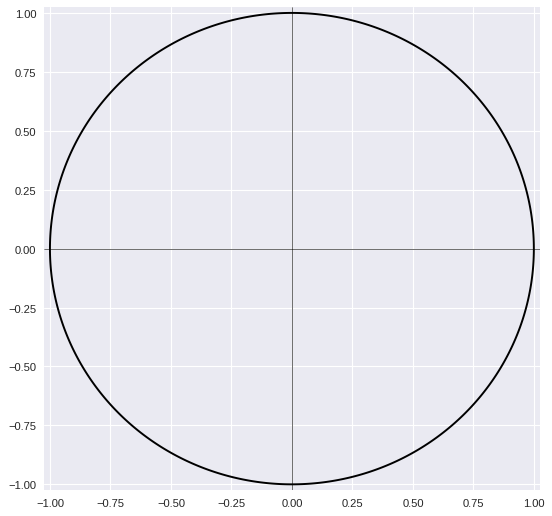

In [4]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
mvn_basics.paint_2d_ellipse_contour(z_unit_circle, x1_unit_circle, x2_unit_circle, ax=ax)

If we then scale this in the 45° direction between the x1 and x2 axis by a factor of 2:

In [5]:
E_45d_ellipse=np.array([[1.0, -1.0], [1.0,  1.0]])
Enormalize_45d_ellipse = 1.0/np.linalg.norm(E_45d_ellipse,axis=0).reshape(1,-1)
E_45d_ellipse=E_45d_ellipse*Enormalize_45d_ellipse
E_45d_ellipse

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [6]:
sqrtGamma_diag_45d_ellipse = np.array([2.0,1.0])
sqrtGamma_45d_ellipse = np.diag(sqrtGamma_diag_45d_ellipse)
sqrtGamma_45d_ellipse

array([[ 2.,  0.],
       [ 0.,  1.]])

In [7]:
A_45d_ellipse=np.dot(E_45d_ellipse, sqrtGamma_45d_ellipse)
A_45d_ellipse

array([[ 1.41421356, -0.70710678],
       [ 1.41421356,  0.70710678]])

Now we have in the notation of [Understanding Statistical Methods through Elliptical Geometry](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.259.3710&rank=1):
$$T = (A\cdot A^T)^{-1}$$

In [8]:
T_45d_ellipse=np.linalg.inv(np.dot(A_45d_ellipse, A_45d_ellipse.T))
T_45d_ellipse

array([[ 0.625, -0.375],
       [-0.375,  0.625]])

As we work with a eigenvector factorization we could have achieved the same result via the fact that $\pmb{T}$ and $\pmb{\Sigma}$ have the same eigenvectors but inverse eigenvalues:

In [9]:
# T = E \Gamma^{-1} E^T
np.dot(E_45d_ellipse, np.dot(np.diag(1/(sqrtGamma_diag_45d_ellipse**2)),E_45d_ellipse.T))

array([[ 0.625, -0.375],
       [-0.375,  0.625]])

In [10]:
S_45d_ellipse = np.linalg.inv(T_45d_ellipse)
S_45d_ellipse

array([[ 2.5,  1.5],
       [ 1.5,  2.5]])

In [11]:
_, z_45d_ellipse, x1_45d_ellipse, x2_45d_ellipse, _ = mvn_basics.generate_2d_ellipse_image(T_45d_ellipse)

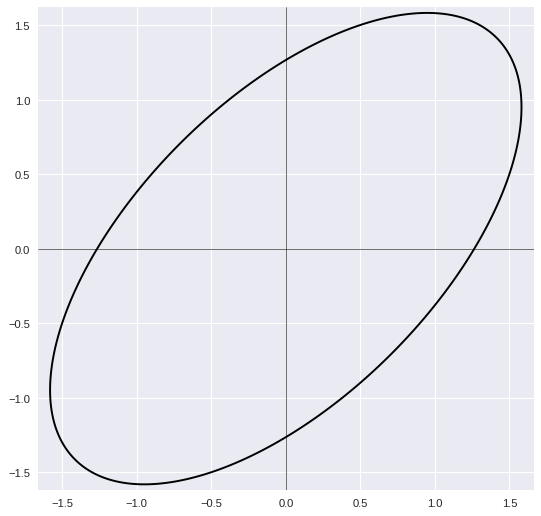

In [12]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.set_aspect('equal', 'datalim')
mvn_basics.paint_2d_ellipse_contour(z_45d_ellipse, x1_45d_ellipse, x2_45d_ellipse, ax=ax)

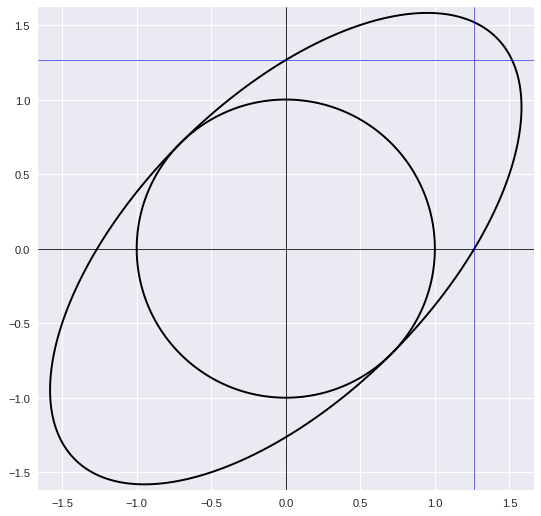

In [13]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.set_aspect('equal', 'datalim')
mvn_basics.paint_2d_ellipse_contour(z_45d_ellipse, x1_45d_ellipse, x2_45d_ellipse, ax=ax)

_, circle, _, _, _ = mvn_basics.generate_2d_ellipse_image(np.diag((1,1)), x1=x1_45d_ellipse, x2=x2_45d_ellipse)
mvn_basics.paint_2d_ellipse_contour(circle, x1_45d_ellipse, x2_45d_ellipse, ax=ax)

# ax.axhline(y=np.sqrt(2.5), color='b', lw=0.5)
ax.axhline(y=1/np.sqrt(T_45d_ellipse[1,1]), color='b', lw=0.5)
ax.axvline(x=1/np.sqrt(T_45d_ellipse[0,0]), color='b', lw=0.5);

Let's try this with another angle. The idea is that we use a direction, e.g. $x=1$ and $y=2$ and create an orthonormal basis with this dirction plus one more vector. This can be done with the QR decomposition, which leaves the direction of the first vector unchanged but makes sure that the second vector is orthogonal. In addition Q is orthonormal, e.g. $QQ^T=I$.

In [14]:
svector = np.array([1, 2]).reshape(-1,1)
dummy = np.array([1, 0]).reshape(-1,1)
E_63d_ellipse = np.hstack([svector, dummy])
E_63d_ellipse

array([[1, 1],
       [2, 0]])

In [15]:
Q_63d_ellipse, _ = scipy.linalg.qr(E_63d_ellipse)
Q_63d_ellipse

array([[-0.4472136 , -0.89442719],
       [-0.89442719,  0.4472136 ]])

In [16]:
sqrtGamma_diag_63d_ellipse = np.array([5.0,1.0])
sqrtGamma_63d_ellipse = np.diag(sqrtGamma_diag_63d_ellipse)
A_63d_ellipse = np.dot(Q_63d_ellipse, sqrtGamma_63d_ellipse)
T_63d_ellipse = np.linalg.inv(np.dot(A_63d_ellipse, A_63d_ellipse.T))
_, z_63d_ellipse, x1_63d_ellipse, x2_63d_ellipse, _ = mvn_basics.generate_2d_ellipse_image(T_63d_ellipse)

In [17]:
A_63d_ellipse

array([[-2.23606798, -0.89442719],
       [-4.47213595,  0.4472136 ]])

In [18]:
T_63d_ellipse

array([[ 0.808, -0.384],
       [-0.384,  0.232]])

In [19]:
S_63d_ellipse = np.linalg.inv(T_63d_ellipse)
S_63d_ellipse

array([[  5.8,   9.6],
       [  9.6,  20.2]])

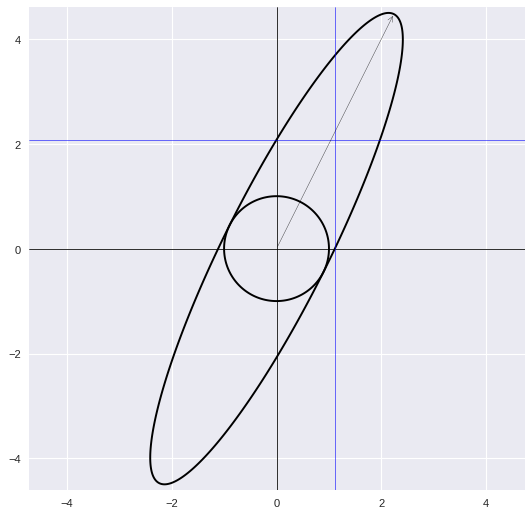

In [20]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.set_aspect('equal', 'datalim')
mvn_basics.paint_2d_ellipse_contour(z_63d_ellipse, x1_63d_ellipse, x2_63d_ellipse, ax=ax)

#ax.arrow(0, 0, A[0,0], A[1,0], head_width=0.05, head_length=0.1, fc='k', ec='k')
ax.annotate('', xy=(-A_63d_ellipse[0,0],-A_63d_ellipse[1,0]), 
            xytext=(0,0), arrowprops=dict(facecolor='k', arrowstyle='->'))

_, circle, _, _, _ = mvn_basics.generate_2d_ellipse_image(np.diag((1,1)), x1=x1_63d_ellipse, x2=x2_63d_ellipse)
mvn_basics.paint_2d_ellipse_contour(circle, x1_63d_ellipse, x2_63d_ellipse, ax=ax)

# ax.axhline(y=np.sqrt(2.5), color='b', lw=0.5)
ax.axhline(y=1/np.sqrt(T_63d_ellipse[1,1]), color='b', lw=0.5)
ax.axvline(x=1/np.sqrt(T_63d_ellipse[0,0]), color='b', lw=0.5);

We call `L_diag_63d_ellipse` the linear transformation for transforming from the original ellipse to the standardized [z-score](https://en.wikipedia.org/wiki/Standard_score) ellipse, which is actually the correlation ellipse. Have a look at the equation on page 6 at the top at [Understanding Statistical Methods through Elliptical Geometry](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.259.3710&rank=1), which explains how an ellipse under linear transformation behaves.

In [21]:
L_diag_63d_ellipse = 1/np.sqrt(np.array([S_63d_ellipse[0,0], S_63d_ellipse[1,1]]))
L_63d_ellipse = np.diag(L_diag_63d_ellipse)
L_63d_ellipse

array([[ 0.4152274 ,  0.        ],
       [ 0.        ,  0.22249708]])

In [22]:
AS_63d_ellipse = np.dot(L_63d_ellipse, A_63d_ellipse)
SS_63d_ellipse = np.dot(AS_63d_ellipse, AS_63d_ellipse.T)
TS_63d_ellipse = np.linalg.inv(SS_63d_ellipse)
SS_63d_ellipse

array([[ 1.        ,  0.88691408],
       [ 0.88691408,  1.        ]])

In [23]:
_, zs_63d_ellipse, _, _, _ = \
    mvn_basics.generate_2d_ellipse_image(TS_63d_ellipse, x1=x1_63d_ellipse, x2=x2_63d_ellipse)

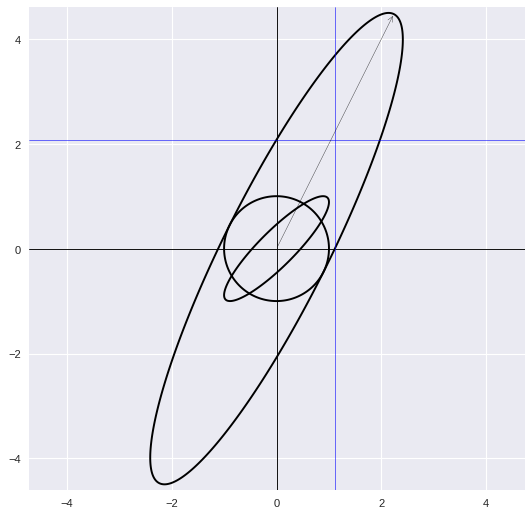

In [24]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.set_aspect('equal', 'datalim')
mvn_basics.paint_2d_ellipse_contour(z_63d_ellipse, x1_63d_ellipse, x2_63d_ellipse, ax=ax)

#ax.arrow(0, 0, A[0,0], A[1,0], head_width=0.05, head_length=0.1, fc='k', ec='k')
ax.annotate('', xy=(-A_63d_ellipse[0,0],-A_63d_ellipse[1,0]), 
            xytext=(0,0), arrowprops=dict(facecolor='k', arrowstyle='->'))

_, circle, _, _, _ = mvn_basics.generate_2d_ellipse_image(np.diag((1,1)), x1=x1_63d_ellipse, x2=x2_63d_ellipse)
mvn_basics.paint_2d_ellipse_contour(circle, x1_63d_ellipse, x2_63d_ellipse, ax=ax)

mvn_basics.paint_2d_ellipse_contour(zs_63d_ellipse, x1_63d_ellipse, x2_63d_ellipse, ax=ax)

# ax.axhline(y=np.sqrt(2.5), color='b', lw=0.5)
ax.axhline(y=1/np.sqrt(T_63d_ellipse[1,1]), color='b', lw=0.5)
ax.axvline(x=1/np.sqrt(T_63d_ellipse[0,0]), color='b', lw=0.5);

At first, by looking at the graph above, I thought that this transformation to the correlation / z-score ellipse may perhaps keep the aspect ratio of the ellipse half axis, which is given as the square root of the ratio of the eigenvalues of the correlation matrix.

## Relationship between the raw and the z-score / correlation ellipses

To check this we get the half-axis of the big ellipse and the half-axis of the scaled correlation / z-score ellipse and find out whether the aspect ratios are equal. We do that symbolically via [sympy](http://www.sympy.org/en/index.html).

In [25]:
# http://docs.sympy.org/latest/modules/matrices/matrices.html
import sympy
sympy.init_printing()

The first thing is to parametrize the big ellipse via an orthogonal set of eigenvalues. In 2 dimensions you only have one free parameter, which is the angle between the x-axis and the first eigen vector. We call that $\varphi$:

In [26]:
# se11, se12, se21, se22 = sympy.symbols('e_{11},e_{12},e_{21},e_{22}')
sephi = sympy.symbols(r'\varphi')
se11 = sympy.cos(sephi)
se21 = sympy.sin(sephi)
se12 = -sympy.sin(sephi)
se22 = sympy.cos(sephi)

se1 = sympy.Matrix([se11, se21])
se2 = sympy.Matrix([se12, se22])
sE = sympy.Matrix(se1)
# sE.col_insert(0, se1)
sE = sE.col_insert(1, se2)
sE, se1, se2

⎛⎡cos(\varphi)  -sin(\varphi)⎤  ⎡cos(\varphi)⎤  ⎡-sin(\varphi)⎤⎞
⎜⎢                           ⎥, ⎢            ⎥, ⎢             ⎥⎟
⎝⎣sin(\varphi)  cos(\varphi) ⎦  ⎣sin(\varphi)⎦  ⎣cos(\varphi) ⎦⎠

Next we define the scaling along these axis as $\gamma_1$ and $\gamma_2$:

In [27]:
sgamma1, sgamma2 = sympy.symbols('\gamma_1,\gamma_2')
sGamma = sympy.diag(sgamma1, sgamma2)
sGamma

⎡\gamma₁     0   ⎤
⎢                ⎥
⎣   0     \gamma₂⎦

And from that we can calculate the $\pmb{A}$ matrix and the $\pmb{\Sigma}$ matrix:

In [28]:
sA = sE * sGamma
sA

⎡\gamma₁⋅cos(\varphi)  -\gamma₂⋅sin(\varphi)⎤
⎢                                           ⎥
⎣\gamma₁⋅sin(\varphi)  \gamma₂⋅cos(\varphi) ⎦

In [29]:
sSigma = sA * sA.T
sSigma

⎡                   2    2                   2    2                           
⎢            \gamma₁ ⋅cos (\varphi) + \gamma₂ ⋅sin (\varphi)              \gam
⎢                                                                             
⎢       2                                    2                                
⎣\gamma₁ ⋅sin(\varphi)⋅cos(\varphi) - \gamma₂ ⋅sin(\varphi)⋅cos(\varphi)      

   2                                    2                          ⎤
ma₁ ⋅sin(\varphi)⋅cos(\varphi) - \gamma₂ ⋅sin(\varphi)⋅cos(\varphi)⎥
                                                                   ⎥
               2    2                   2    2                     ⎥
        \gamma₁ ⋅sin (\varphi) + \gamma₂ ⋅cos (\varphi)            ⎦

The $\pmb{T}$ matrix is simply the inverse of the $\pmb{\Sigma}$ matrix:

In [30]:
sT = sSigma ** -1
sT

⎡                                                                             
⎢⎛       2    2                   2    2         ⎞ ⎛       2    2             
⎢⎝\gamma₁ ⋅sin (\varphi) + \gamma₂ ⋅cos (\varphi)⎠⋅⎝\gamma₁ ⋅cos (\varphi) + \
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                  ⎛       2    2             
⎢                                                  ⎝\gamma₁ ⋅cos (\varphi) + \
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                            ─
⎢                                                                             
⎢                                                   

In order to get the correlation / z-score matrix we have to scale each direction by the $\sigma_i$ of the direction. The $\pmb{\Sigma}$ matrix contains the squares $\sigma_i^2$ on the diagonal:

In [31]:
sScale = sympy.diag(sSigma[0,0] ** (-1/2), sSigma[1,1]** (-1/2))
sScale

⎡                                                 -0.5                        
⎢⎛       2    2                   2    2         ⎞                            
⎢⎝\gamma₁ ⋅cos (\varphi) + \gamma₂ ⋅sin (\varphi)⎠                            
⎢                                                                             
⎢                                                                             
⎢                                                       ⎛       2    2        
⎣                          0                            ⎝\gamma₁ ⋅sin (\varphi

                               ⎤
                               ⎥
    0                          ⎥
                               ⎥
                           -0.5⎥
           2    2         ⎞    ⎥
) + \gamma₂ ⋅cos (\varphi)⎠    ⎦

We then create the correlation matrix by scaling our $\pmb{A}$ matrix and generating from that the correlation matrix (the z-score $\pmb{\Sigma}$ matrix):

In [32]:
sAc = sScale * sA
sCorr = sympy.simplify(sAc * sAc.T)
sCorr

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢    ⎛       2          2⎞ ⎛         2                         2          2   
⎣1.0⋅⎝\gamma₁  - \gamma₂ ⎠⋅⎝- \gamma₁ ⋅cos(2⋅\varphi) + \gamma₁  + \gamma₂ ⋅co

                                                                              
                                                                              
                     1                                                        
                                                                              
                        -0.5                                                  
                      2⎞     ⎛       2             

From that we can now retrieve the eigenvalues:

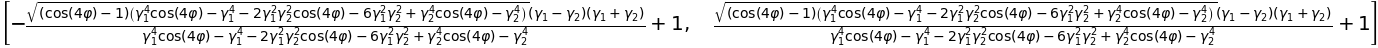

In [33]:
list(sCorr.eigenvals())

And generate the square root of the relation beween the eigenvalues:

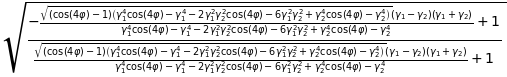

In [34]:
sCorr2D_eval_relation = sympy.sqrt(list(sCorr.eigenvals())[0]/list(sCorr.eigenvals())[1])
sCorr2D_eval_relation

This does not look like a simple expression, e.g. latest here we can see that our visual cue from above is most likely wrong.

A simple way to check is to verify with some numeric values.

The first verification is that if we had our original ellipse aligned with the 45° axis between the x-axis and the y-axis then we would expect that the scaled ellipse should keep the aspect ratio:

In [35]:
sgamma2_value = 1.0
sgamma1_factor = 20.0
sgamma1_value = sgamma1_factor * sgamma2_value
sephi_value_45_degrees = 45.0/180.0*np.pi
sCorr2D_eval_relation.subs(sephi, sephi_value_45_degrees).subs(sgamma1, sgamma1_value).subs(sgamma2, sgamma2_value)

Which is 20, as expected by our input of `sgamma1_factor=20`. The correlation matrix looks like this:

In [36]:
sCorr.subs(sephi, sephi_value_45_degrees).subs(sgamma1, sgamma1_value).subs(sgamma2, sgamma2_value)

⎡       1          0.99501246882793⎤
⎢                                  ⎥
⎣0.99501246882793         1        ⎦

Now let's see what happens if we chose another angle, e.g. 10°:

In [37]:
sephi_value_10_degrees = 10.0/180.0*np.pi
sCorr2D_eval_relation.subs(sephi, sephi_value_10_degrees).subs(sgamma1, sgamma1_value).subs(sgamma2, sgamma2_value)

Now this aspect ratio of the correlation ellipse half axis departs considerably from the aspect ratio of the half axis of our original ellipse. This concludes that the original assumption was wrong.

The correlation matrix here looks like this:

In [38]:
sCorr.subs(sephi, sephi_value_10_degrees).subs(sgamma1, sgamma1_value).subs(sgamma2, sgamma2_value)

⎡        1          0.959626012001704⎤
⎢                                    ⎥
⎣0.959626012001704          1        ⎦

You can see that there is no relationship between the correlation matrices or their associated ellipses with the original data ellipse that we used as a starting point. The only way to see that basically two data ellipses are the same is by looking at the eigenvalues of the original data ellipses. If they have the same eigenvalues then the two ellipses are the same and may only be rotated.

# Scale measures of the Multi-Varite Normal

## Mahalanobis distance

How would you anser the question if a given $\pmb{x}_i\in\mathbb{R}^N$ is "strange" in terms of its size, e.g. if you would expect to see such values or if they are a surprise? 

In the univariate case you compare $|x_i-\mu|$ with $\sigma$ and you know that between $\mu-\sigma$ and $\mu+\sigma$ there are roughly $68\%$ of the probability mass ([68–95–99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule), [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation)). Therefore you would be surprised to see an $x_i$ that is much further away from $\mu$ than let's say $3\sigma$.

In the multi-variate case the level of "surprise" depends on the direction. For the further discussion I will drop the $\mu$ and assume that we talk about a random vector where $\pmb{\mu}=0$. What still remains true, though is that the exponent of the multi-variate normal distribution depends on:
$$p(\pmb{x}_i)\sim\exp(-\frac{1}{2}\pmb{x}_i^T\pmb{\Sigma}^{-1}\pmb{x})$$
Therefore $\pmb{x}_i^T\pmb{\Sigma}^{-1}\pmb{x}$ (which is a raw number like $0.7$ or $1.24$ or similar) plays the role of the (square of the) factor in front of the $\sigma$ in the univariate case. This is actually the basis of the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance). As the Wikipedia page says:

> For a normal distribution in any number of dimensions, the probability of an observation is uniquely determined by the Mahalanobis distance d. Specifically, $d^{2}$ is [chi-squared distributed](https://en.wikipedia.org/wiki/Chi-squared_distribution). If the number of dimensions is $2$, for example, the probability of a particular calculated $d$ being less than some threshold $t$ is $p(d< t)=
1-e^{-t^2/2}$. To determine a threshold to achieve a particular probability, $p$, use $t=\sqrt{-2\ln(1-p)}$, for $2$ dimensions. For number of dimensions other than 2, the [cumulative chi-squared distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution#Cumulative_distribution_function) should be consulted.

Let's cross check some of this. Let's first check if the values we get are correct for the univariate case with which we can easily compare. In the univariate case the degree of freedom of the $\chi^2$ distribution is $1$:

In [39]:
degrees_of_freedom = 1
threshold_t = 1
scipy.stats.chi2.cdf(threshold_t, degrees_of_freedom)

Which fits to our expectation that in the univariate case $68\%$ of the probability mass are between $\mu-\sigma$ and $\mu+\sigma$.

If you wanted to know in the univariate case the value of the cumulative probability mass between $\mu-2\sigma$ and $\mu+2\sigma$ you would have to look at a $t$ of $t=2^2=4$:

In [40]:
degrees_of_freedom = 1
threshold_t = 4
scipy.stats.chi2.cdf(threshold_t, degrees_of_freedom)

Which, of course, again matches our expectations.

How would that look like for 2 dimensions? How much cumulative probability mass would be within the ellipse of the $d=1$?

In [41]:
degrees_of_freedom = 2
threshold_t = 1
scipy.stats.chi2.cdf(threshold_t, degrees_of_freedom)

So you would need to pick a larger "radius" of the ellipse in order to catch again $68\%$ of the probability mass, but you see that the principle still works. The paper [Understanding Statistical Methods through Elliptical Geometry](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.259.3710&rank=1) shows on page 9 a so called [sunflower plot](http://sas-and-r.blogspot.de/2011/03/example-832-histdata-package-sunflower.html) with the $40\%$, $68\%$ and the $95\%$ data ellipses. In order to get the corresponding "radiuses" you need to invert the cumulative chi-square distribution. This is called in `scipy` the percent-point function. Let's first check this with a known value:

In [42]:
scipy.stats.chi2.ppf(0.39346, degrees_of_freedom)

If we would want to calculate the "radius" of the $95\%$ data ellipse we would need to get $0.95=\chi_2^2(c^2)\Rightarrow c^2\approx 5.99$.

In [43]:
scipy.stats.chi2.ppf(0.95, degrees_of_freedom)

If we would want to plot this larger data ellipse we would do it as follows:

In [44]:
z_63d_ellipse_95pct_contour_level = scipy.stats.chi2.ppf(0.95, degrees_of_freedom)
_, z_63d_ellipse_95pct, x1_63d_ellipse_95pct, x2_63d_ellipse_95pct, _ = \
    mvn_basics.generate_2d_ellipse_image(T_63d_ellipse, 
                                         contour_level=z_63d_ellipse_95pct_contour_level)

In order to compare this to data points generated by a MVN distribution we generate some data-points:

In [45]:
rvs_63d_ellipse = scipy.stats.multivariate_normal.rvs([0,0], S_63d_ellipse, 500, 
                                                      random_state=np.random.RandomState(42))

Now let's plot that:

In [46]:
# https://stackoverflow.com/questions/8457110/how-to-vectorize-the-evaluation-of-bilinear-quadratic-forms
X_ = np.matrix(rvs_63d_ellipse.T)
A_ = np.matrix(T_63d_ellipse)
select_ = ((X_.T*A_).A * X_.T.A).sum(1) > z_63d_ellipse_95pct_contour_level
np.sum(select_)

21

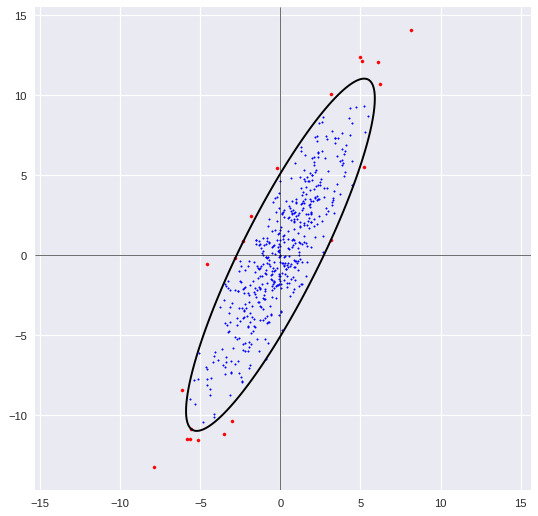

In [47]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.set_aspect('equal', 'datalim')
mvn_basics.paint_2d_ellipse_contour(z_63d_ellipse_95pct, x1_63d_ellipse_95pct, x2_63d_ellipse_95pct, ax=ax,
                                   contour_level=z_63d_ellipse_95pct_contour_level)
ax.scatter(rvs_63d_ellipse[select_,0], rvs_63d_ellipse[select_,1], s=8, c='r');
ax.scatter(rvs_63d_ellipse[~select_,0], rvs_63d_ellipse[~select_,1], s=2, c='b');

We would expect to see $5\%$ of points outside the ellipse, which would be for $500$ data points a total of $25$ data points. In our example we have $21$ points outside the ellipse. Good enough.

The Wikipedia article about the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) says:

> If each of these axes is rescaled to have unit variance, then Mahalanobis distance corresponds to standard Euclidean distance in the transformed space.

I believe this is wrong as also the following calculation indicates in the 2-dimensional case:

In [48]:
sx1, sx2, srho = sympy.symbols(r'x_{1}, x_{2}, \varrho')
sxvec = sympy.Matrix([sx1, sx2])
scorr = sympy.Matrix([[1, srho], [srho, 1]])
sxvec.T * scorr * sxvec

[x_{1}⋅(\varrho⋅x_{2} + x_{1}) + x_{2}⋅(\varrho⋅x_{1} + x_{2})]

In [49]:
sx1**2+2*srho*sx1*sx2+sx2**2

This differs by the factor $2\varrho x_1x_2$ from the Euclidean distance. It also intuitively makes sense that even in the case of rescaling the axis to unit variance the ellipse may still be "stretched" and therefore the Mahalanobis distance cannot be the simply Euclidean distance.

In [50]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

#HTML('<style>{}</style>'.format(CSS))

## Total variation

If you have a set of vectors from a multi-variate normal, like above the `rvs_63d_ellipse`, where we have 500 2-dimensional vectors. What would we expect their average squared distance from the center to be?
$$\left<\pmb{x}^2\right> = \frac{1}{N-1}\sum_{i=1}^N  |\pmb{x}_i|^2$$
In the univariate case this would basically be (in case of large samples) the [sample variance](https://en.wikipedia.org/wiki/Variance#Sample_variance). In the multi-variate case this idea leads us to the so called [**Total Variation**](https://onlinecourses.science.psu.edu/stat505/node/21).

In the case of $D$ dimensions this is:
$$\left<\pmb{x}^2\right> = \frac{1}{N-1}\sum_{i=1}^N  |\pmb{x}_i|^2 = \frac{1}{N-1}\sum_{i=1}^N \sum_{d=1}^D  x_{id}^2
=\sum_{d=1}^D\frac{1}{N-1}\sum_{i=1}^N  x_{id}^2
=\sum_{d=1}^D{\sigma_d^s}^2
$$
The ${\sigma_d^s}^2$ are given by the diagonal elements of the sample covariance matrix and you can write the sum as:
$$
\DeclareMathOperator{\tr}{tr}
\left<\pmb{x}^2\right>=\tr(\Sigma^s)
$$

As the trace of a matrix is [invariant under basis transformations](https://en.wikipedia.org/wiki/Trace_(linear_algebra) you have:
$$
\left<\pmb{x}^2\right>=\tr(\Sigma^s)=\sum_i\lambda_i^s
$$
Which means that the total variation is the sum of the eigenvalues of the sample covariance matrix.

Let's check this. The following three expressions are:
* the expected square distance of the center $\left<\pmb{x}^2\right>$
* the trace of the sample covariance matrix and
* the sum of the eigenvalues of the sample covariance matrix

In [51]:
np.sum(rvs_63d_ellipse**2)/(rvs_63d_ellipse.shape[0]-1)

In [52]:
np.trace(np.cov(rvs_63d_ellipse.T))

In [53]:
S_sample_63d_ellipse = np.cov(rvs_63d_ellipse.T)
S_sample_63d_ellipse_evd = np.linalg.eigh(S_sample_63d_ellipse)
idx = S_sample_63d_ellipse_evd[0].argsort()[::-1]
S_sample_63d_ellipse_evd = (S_sample_63d_ellipse_evd[0][idx], S_sample_63d_ellipse_evd[1][:,idx])
display_side_by_side(S_sample_63d_ellipse_evd[0], S_sample_63d_ellipse_evd[1])

0 
 
 
 
 
 0 
 23.380 
 
 
 1 
 0.983 
 
 
 
 
 
 
 0 
 1 
 
 
 
 
 0 
 0.442 
 -0.897 
 
 
 1 
 0.897 
 0.442

In [54]:
np.sum(S_sample_63d_ellipse_evd[0])

Just as a side remark: if we would have calculated the covariance matrix by hand ourselves via its definition:
$$\Sigma^s=\frac{1}{N-1}X^TX$$
We would have got an exact match of the results:

In [55]:
np.trace(np.dot(rvs_63d_ellipse.T,rvs_63d_ellipse)/(rvs_63d_ellipse.shape[0]-1))

I am not sure in what exact detail the `numpy.cov` function differs from our calculation by hand so that it ends up with slightly different results.

### The Frobenius norm and singular values

The [summary of the singular value decomposition](http://www.cs.cmu.edu/~venkatg/teaching/CStheory-infoage/SVD-chap.pdf) from [Venkatesan Guruswami](http://www.cs.cmu.edu/~venkatg/) that I mentioned already at the very top contains a proof of his lemma 4.2, that the sum of squares of the singular values equals the square of the [Forbenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm). In numpy the Frobenius norm is the standard for `numpy.linalg.norm` and the definition is given by:
$$||A||_F=\sqrt{\sum_{ij} a_{ij}^2}$$

Normally the singular values are denoted by $\sigma$, but as we already used $\sigma$ to denote the standard deviation we will use $\kappa$ to denote the singular values. Then the lemma 4.2 reads:
$$||A||_F^2=\sum_i\kappa_i^2(A)$$

If we now look at our expression for $\left<\pmb{x}^2\right>$ we see that:
$$\left<\pmb{x}^2\right> = \frac{1}{N-1}||X||_F^2$$

Here is the expression directly via the Frobenius norm:

In [56]:
np.linalg.norm(rvs_63d_ellipse)**2/(rvs_63d_ellipse.shape[0]-1)

And here is the expression via the singular value decomposition:

In [57]:
rvs_63d_ellipse_svd = np.linalg.svd(rvs_63d_ellipse)
display_side_by_side(rvs_63d_ellipse_svd[2],-Q_63d_ellipse)

,0,1
0,0.442,0.897
1,0.897,-0.442
,0,1
0,0.447,0.894
1,0.894,-0.447


The left singular vectors of `rvs_63d_ellipse` are a large matrix and therefore we don't display it above:

In [58]:
rvs_63d_ellipse_svd[0].shape

The right singular vectors of `rvs_63d_ellipse` are basically the same as our `Q_63d_ellipse` that was the input to our construction.

Here are the singular values themselves:

In [59]:
rvs_63d_ellipse_svd[1]

array([ 108.01196073,   22.16476073])

And here we verify that the result of lemma 4.2 match:

In [60]:
np.sum(rvs_63d_ellipse_svd[1]**2)/(rvs_63d_ellipse.shape[0]-1)

### Connection between the singular values of $X$ and eigenvalues of the sample covariance matrix

The sample covariance matrix is defined as:
$$\Sigma^s=\frac{1}{N-1}X^TX$$

In [61]:
np.cov(rvs_63d_ellipse.T)

array([[  5.3617967 ,   8.88207375],
       [  8.88207375,  19.00109602]])

In [62]:
np.dot(rvs_63d_ellipse.T,rvs_63d_ellipse)/(rvs_63d_ellipse.shape[0]-1)

array([[  5.36335326,   8.88209052],
       [  8.88209052,  19.0010962 ]])

So we see that the core of the sample covariance matrix is $X^T\cdot X$.

The following is taken from chapter 12.2.3 "Singular value decomposition (SVD)" in [Machine Learning: A Probabilistic Perspective](https://www.amazon.com/Machine-Learning-Probabilistic-Perspective-Computation/dp/0262018020).

If you have The SVD of $X$ as:
$$X=U\cdot S\cdot V^T$$
where $X\in\mathbb{R}^{N\times D}$ then
$$X^T\cdot X=VS^TU^TUSV^T=VDV^T$$
where $D=S^2$ is a diagonal matrix containing the squared singular values. Hence
$$(X^TX)V=VD$$
so:
* the eigenvectors of $(X^TX)$ are equal to V (this we've seen already above where we looked at the right singular vectors of `rvs_63d_ellipse` and saw that they are the same as our `Q_63d_ellipse` matrix of eigenvectors of the covariance matrix) and 
* the eigenvalues are equal to the diagonal elements of $D$. 

This means:
$$\kappa_i^2(X)=\lambda_i(X^TX)=(N-1)\cdot\lambda_i(\Sigma^s)$$

And together with the lemma 4.2 above we have:
$$||X||_F^2=\sum_i\kappa_i^2(X)=(N-1)\cdot\sum_i\lambda_i(\Sigma^s)=(N-1)\cdot\tr(\Sigma^s)$$

Here is a summary of what we've done so far:

$$\left<\pmb{x}^2\right>=\tr(\Sigma^s)=\sum_i\lambda_i^s=\frac{1}{N-1}||X||_F^2=\frac{1}{N-1}\sum_i\kappa_i^2(X)$$

### Connection between the singular values and eigenvalues of the covariance matrices

In the answer 1 to the stackexchange question [Relationship between eigendecomposition and singular value decomposition](https://math.stackexchange.com/questions/28036/relationship-between-eigendecomposition-and-singular-value-decomposition) they clarify the relationship of the singular value decomposition and the eigen decomposition for symmetric matrices. This only works for symmetric matrices, which is the case for covariance matrices. Covariance matrices are not only symmetric but even [non-negative definite](https://en.wikipedia.org/wiki/Positive-definite_matrix).

The below is valid for any non-negative definite symmetric matrix. Therefore we can also perform our example calculations on the distribution covariance matrix and not on the sample covariance matrix, which gives nicer numeric results.

In numpy there exists an optimized version for the eigen decomposition for symmetric ([hermitian](https://en.wikipedia.org/wiki/Hermitian_matrix)) matrices `numpy.linalg.eigh`:

In [63]:
S_63d_ellipse_evd = np.linalg.eigh(S_63d_ellipse)
idx = S_63d_ellipse_evd[0].argsort()[::-1]
S_63d_ellipse_evd = (S_63d_ellipse_evd[0][idx], S_63d_ellipse_evd[1][:,idx])
display_side_by_side(S_63d_ellipse_evd[0], S_63d_ellipse_evd[1])

0 
 
 
 
 
 0 
 25.000 
 
 
 1 
 1.000 
 
 
 
 
 
 
 0 
 1 
 
 
 
 
 0 
 0.447 
 -0.894 
 
 
 1 
 0.894 
 0.447

Above we re-sorted the eigenvalues in descending order, so that we can compare them with the singular values below.

Actually the above result is expected alone because of the way how we constructed the matrix `S_63d_ellipse` and we could have taken directly the ingredients of our construction process:

In [64]:
display_side_by_side(sqrtGamma_diag_63d_ellipse**2, Q_63d_ellipse)

0 
 
 
 
 
 0 
 25.000 
 
 
 1 
 1.000 
 
 
 
 
 
 
 0 
 1 
 
 
 
 
 0 
 -0.447 
 -0.894 
 
 
 1 
 -0.894 
 0.447

The reversal of signes of the first eigenvector does not matter as you have two sign choices when determining a normalized eigen vector from a matrix $A$:
$$\pmb{A}\cdot\pmb{v} = \lambda \pmb{v}$$
Reversing the sign of $\pmb{v}$ would deliver the same result.

Now let's look at the singular value decomposition of `S_63d_ellipse`:

In [65]:
S_63d_ellipse_svd = np.linalg.svd(S_63d_ellipse)
display_side_by_side(S_63d_ellipse_svd[0], S_63d_ellipse_svd[1], S_63d_ellipse_svd[2])

0 
 1 
 
 
 
 
 0 
 -0.447 
 -0.894 
 
 
 1 
 -0.894 
 0.447 
 
 
 
 
 
 
 0 
 
 
 
 
 0 
 25.000 
 
 
 1 
 1.000 
 
 
 
 
 
 
 0 
 1 
 
 
 
 
 0 
 -0.447 
 -0.894 
 
 
 1 
 -0.894 
 0.447

We see that the singular values match and the left and right singular vectors are the same (perhaps inverted and pointing into the other direction, e.g. multiplied by $-1$) as the eigenvectors.

In the stackexchange question we have a symmetric matrix $A$, which can be decomposed via the SVD:
$$A=U\Sigma V^T$$
Here $V$ is almost $U$ except for the signs of columns of $V$ and $U$.

Or via the EVD:
$$
\DeclareMathOperator{\sign}{sign}
A=W\Lambda W^T=\sum_i w_i\lambda_i w_i^T=\sum_i w_i|\lambda_i|\sign(\lambda_i) w_i^T
$$

The left singular vectors $u_i$ are $w_i$ and the right singular vectors $v_i$ are $\sign(\lambda_i)w_i$. As the covariance matrix is even non-negative definite we know that $\sign{\lambda_i}=+1$ and the singular value decomposition and the eigenvalue decomposition deliver the exact same results. 

So the summary is that for non-negative definite symmetric matrices like the covariance or sample covariance matrix the eigenvalue decomposition is the same as the singular value decomposition. We can extend our summary from above to:

$$\kappa_i(X^TX)=\kappa_i^2(X)$$

$$\left<\pmb{x}^2\right>=\tr(\Sigma^s)=\sum_i\lambda_i^s=\frac{1}{N-1}||X||_F^2=\frac{1}{N-1}\sum_i\kappa_i^2(X)=\sum_i\kappa_i(\Sigma^s)$$

### Relationships for the distribution covariance matrix

Above we've constructed all of our results based on the sample matrix $X$ and the sample covariance matrix $\Sigma^s$. How does this look like for our distribution covariance matrix $\Sigma$?

Based on our construction:
$$\Sigma=AA^T=E\cdot\Gamma\cdot E^T$$
we get

$$\kappa_i(AA^T)=\kappa_i^2(A)$$
$$\tr(\Sigma)=\sum_i\lambda_i=\sum_i\kappa_i^2(A)=\sum_i\kappa_i(\Sigma)$$

In [66]:
np.trace(S_63d_ellipse)

In [67]:
np.sum(S_63d_ellipse_evd[0])

In [68]:
A_63d_ellipse_svd = np.linalg.svd(A_63d_ellipse)
A_63d_ellipse_svd[1]

array([ 5.,  1.])

In [69]:
np.sum(A_63d_ellipse_svd[1]**2)

In [70]:
np.sum(S_63d_ellipse_svd[1])

Alltogether we have:
$$
\left<\pmb{x}^2\right>=\tr(\Sigma^s)=\sum_i\lambda_i^s=\frac{1}{N-1}||X||_F^2=\frac{1}{N-1}\sum_i\kappa_i^2(X)=\sum_i\kappa_i(\Sigma^s)
\approx
\tr(\Sigma)=\sum_i\lambda_i=\sum_i\kappa_i^2(A)=\sum_i\kappa_i(\Sigma)
$$

### "Fraction of variance unexplained" and "explained variation"

The above is quite useful once we look into quantifying the error of a model compared to the "reality".

In statistics, [explained variation](https://en.wikipedia.org/wiki/Explained_variation) measures the proportion to which a mathematical model accounts for the variation (dispersion) of a given data set. Often, variation is quantified as variance; then, the more specific term explained variance can be used.

This leads us to [fraction of variance unexplained](https://en.wikipedia.org/wiki/Fraction_of_variance_unexplained): In statistics, the fraction of variance unexplained (FVU) in the context of a regression task is the fraction of variance of the regressand (dependent variable) Y which cannot be explained, i.e., which is not correctly predicted, by the explanatory variables X.

### Total Variation in the z-scale / correlation matrix scale

Usual practice is to rescale your data to the [z-scale](https://en.wikipedia.org/wiki/Standard_score) via for example the [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) in sklearn.

In [71]:
rvs_63d_ellipse_zscaler = sklearn.preprocessing.StandardScaler()
rvsS_63d_ellipse = rvs_63d_ellipse_zscaler.fit_transform(rvs_63d_ellipse)

In that case you have as the covariance matrix the correlation matrix and the diagonal elements are all $1.0$ and the $\tr{\Sigma_z}$ equals the number of dimensions: $\tr{\Sigma_z}=D$.

In the z-scaled system we have:
$$
\begin{eqnarray}
\sigma_d&=&1&\quad\hbox{all variances and sigmas are scaled to $1.0$}\\
\tr{\Sigma_z}&=&\sum_d \sigma_d=D&\quad\hbox{the trace of the correlation matrix corresponds to the number of dimensions}\\
\tr{\Sigma_z}&=&\sum_i{\lambda_z}_i&\quad\hbox{as the trace is invariant under basis transformations}\\
\left<z^2\right>&=&\sum_d {\sigma_d^s}^2\approx\sum_d {\sigma_d}^2=D&\quad\hbox{this is the relationship between the sample variance ${\sigma_d^s}^2$ and the variance of the underlying distribution $\sigma_d^2$}\\
\left<z^2\right>&=&||Z||_F^2/(N-1)\approx D&\\
1.0&\approx&||Z||_F^2/((N-1)\cdot D)&\\
\end{eqnarray}
$$

In [72]:
np.linalg.norm(rvsS_63d_ellipse)**2/(rvs_63d_ellipse.shape[0]-1)

In [73]:
SS_63d_ellipse_evd = np.linalg.eigh(SS_63d_ellipse)
idx = SS_63d_ellipse_evd[0].argsort()[::-1]
SS_63d_ellipse_evd = (SS_63d_ellipse_evd[0][idx], SS_63d_ellipse_evd[1][:,idx])
display_side_by_side(SS_63d_ellipse_evd[0], SS_63d_ellipse_evd[1])

0 
 
 
 
 
 0 
 1.887 
 
 
 1 
 0.113 
 
 
 
 
 
 
 0 
 1 
 
 
 
 
 0 
 0.707 
 -0.707 
 
 
 1 
 0.707 
 0.707

In [74]:
np.sum(SS_63d_ellipse_evd[0])

## Generalized Variance

The total variation does not take into account the correlation between the variables. To take into account the correlations among pairs of variables an alternative measure of overall variance is suggested, the so called [**Generalized Variance**](http://faculty.ucr.edu/~ashis/publication/publications/ESS6053.PDF). By definition the generalized variance of a random vector $\pmb{X}$ is equal to $\left|\pmb{\Sigma}\right|$, where $\left|\pmb{\Sigma}\right|$ means the determinante of $\pmb{\Sigma}$.

If we see the variance ellipsoid as generated by the transformation $\pmb{A}$ as described at the very top:
$$\mathcal{E}=\pmb{\mu}+\pmb{A}\mathcal{S}$$
Then the volume of the ellipsoid is given by:
$$V(\mathcal{E})=V(\mathcal{S})\cdot\left|\pmb{A}\right|$$
So the determinante of $\pmb{A}$ is a measure of the volume of the variance ellipsoid. If we then add the fact that
$$\left|\pmb{A}\right|^2=\left|\pmb{\Sigma}\right|$$
then we see that the generalized variance is something like the square of the volume of the ellipsoid.

## Other measures of dispersion

Other measures of the dispersion of a multi-variate normal distribution have been proposed like in the paper [A measure for total variability in multivariate normal distribution](http://www.survo.fi/publications/Mustonen1997.pdf) by Seppo Mustonen. This paper also goes into the details of the problems of the total variation or the generalized variance.